# Estimation of the mean and standar deviation: Mixed Layer depth and Sea Surface Height

On this notebook we find described the code used to get a plot of the ime mean and standard deviation of the mixed layer depth (MLD) and for the sea surface heiht (SSH) over one region. For the sake of brevity, the notebook only considers one example for one of the [regions](./Distribution-regions.ipynb), of the Gulf Stream. 

This notebook has the following structure:

    1. Imported modules
    2. Dictionaries used
    3. Functions
    4. Example plots
        4.1 Mean MLD
        4.2 Mean SSH

Figures of this kind can be found in the written report [MLD project](https://www.overleaf.com/read/rmjfbdbbrsbf
), in the Sections (3.1), (3.2.1), (4.1), (4.2.1) (5.1), (5.2.1), the Chapter 6 and the Appendix A.1.1. 

In the case of the figures in the Appendix A the mean is calculated using a period 2006-2015, and it also considers the ISAS dataset. This code is also useful for ISAS dataset. Therefore, a couple of commented lines are added.

## 1. Imported modules

In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd

from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.animation as animation
from IPython.display import HTML

## This module disable the print of warnings in the notebook
import warnings; warnings.simplefilter('ignore')

## 2. Dictionaries

In [2]:
"""
subregions is a dictionary that has the coordinate
boundaries of the sub-regions. The format is:
<subregion> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

subregions = {
    'lab': {
        'lon' : (-55, -51),
        'lat' : (56, 59),
        'name' : 'Labrador Sea'
    },
    'irm': {
        'lon' : (-39, -35),
        'lat' : (58, 61),
        'name' : 'Irminger Sea'
    },
    'gul': {
        'lon' : (-57, -53),
        'lat' : (34, 38),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-20, -16),
        'lat' : (50, 53),
        'name' : 'North East Sea'
    },
    'nor1': {
        'lon' : (-2, 2),
        'lat' : (73, 76),
        'name' : 'Nordic Sea- Northern'
    },
    'nor2': {
        'lon' : (0, 4),
        'lat' : (68, 71),
        'name' : 'Nordic Sea- Southern'
    }   
}


"""
reg_ext is a dictionary that has the coordinate
boundaries of the main regions. The format is:
<region> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-25, 20),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 50.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}


## 3. Functions

In [3]:
def Crops(coord, data_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        data_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = data_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)



def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)



def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')


    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)



def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)
    

## 4. Example plots

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################


dir_1 = '../../../New_ARMOR/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'
#dir_2= '/net/alpha/exports/sciences/data/LPO_ISAS/ANA_ISAS15/fld2D/' #ISAS directory
dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'     #Output dir. Plots


fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'
#fl_n2 = 'ISAS15_DM_2002_2015_MLDS_0.03.nc'
#fl_n3 = 'ISAS15_DM_2002_2015_MLDS_0.015.nc'
#fl_n4 = 'ISAS15_DM_2002_2015_MLDS_0.046.nc'


c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)
#c_isas1 = xr.open_dataset(dir_2 + fl_n2, autoclose=True)
#c_isas2 = xr.open_dataset(dir_2 + fl_n3, autoclose=True)
#c_isas3 = xr.open_dataset(dir_2 + fl_n4, autoclose=True)

In [18]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

In [19]:
reg = 'gul'

gul1 = Crops(reg, c_armor1)
gul15 = Crops(reg, c_armor15)
gul_small = gul1.sel(time=slice('2006-01-01', '2015-12-31'))

#gulfI1 = Crops(reg, c_isas1)
#gulfI2 = Crops(reg, c_isas2)
#gulfI3 = Crops(reg, c_isas3)

In [20]:
gul15 = Masking(gul15, gul15.to[0,25])    # to[0,18] if is the Nordic Sea

In [ ]:
#del c_armor1, c_armor15, c_isas1, c_isas2, c_isas3

### 4.1 Mean ARMOR complete:: 2005-2018

In [7]:
mean1 = gul1.mean(dim='time', skipna=True)
stdv1 = gul1.std(dim='time', skipna=True)

min_mldm, max_mldm = Limits(mean1.mlotst.where(gul15.mask == 1))    # Min, max values mean MLD
min_mlds, max_mlds = Limits(stdv1.mlotst.where(gul15.mask == 1))    # Min, max values std MLD

print(min_mldm, max_mldm, min_mlds, max_mlds)

13.748971193415638 72.01097393689986 3.852396992833297 78.65533077465841


In [8]:
# Variables to plot
mapping_var = mean1.mlotst.where(gul15.mask == 1)    # In the colormap
contour_var = stdv1.mlotst.where(gul15.mask == 1)    # Variable to plot in lines

In [ ]:
# If the dataset is ISAS
#mapping_var = meanI3.MLDP[0]    # In the colormap
#contour_var = stdvI3.MLDP[0]   # Variable to plot in lines


In [9]:
## Title for the figure
fig_title = 'Gulf Strean Mixed Layer Depth [m]' 

cb_label = 'mean MLD [m]'    # Label for colorbar
cmap = 'YlGnBu'
levels = np.linspace(13., 73., 20)
n_lines = 11

<IPython.core.display.Javascript object>


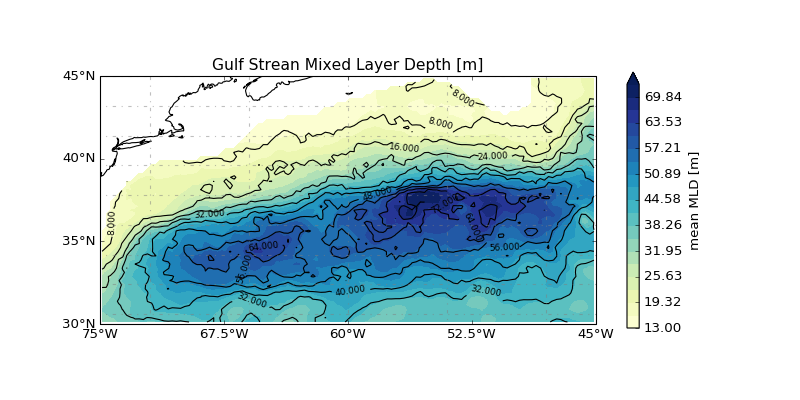

In [10]:
%matplotlib notebook

plt.close()

lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

xtick = np.linspace(lon1, lon2, num=5)
ytick = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(gul1)
projection = ccrs.PlateCarree(360)
 

fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), 
                        figsize=(10,5)) 

Map(ax, region, xtick, ytick)

contr1 = ax.contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='max')
cbar = fig.colorbar(contr1, ax=ax, shrink=0.8, orientation='vertical',
                    label=cb_label) 
contr2 = ax.contour(x_n, y_n, contour_var, n_lines, linewidths=1, colors='k')

ax.clabel(contr2, fontsize=8, inline=10)
ax.set_title(fig_title, fontsize=14)

#plt.savefig(dir_o + 'Gul-mld-ms.png', bbox_inches='tight')
plt.show()

### 4.2 Mean + std :: geopotential heigth

In [12]:
mean15 = gul15.mean(dim='time', skipna=True)
stdv15 = gul15.std(dim='time', skipna=True)

min_mldm15, max_mldm15 = Limits(mean15.mlotst.where(gul15.mask == 1))    # Min, max values mean MLD
min_mlds15, max_mlds15 = Limits(stdv15.mlotst.where(gul15.mask == 1))    # Min, max values std MLD

print(min_mldm15, max_mldm15, min_mlds15, max_mlds15)

16.69106 106.04063 7.3419704 288.92053


In [14]:
# Variables to plot
mapping_var = stdv15.zo[0].where(gul15.mask == 1)    # In the colormap
contour_var = mean15.zo[0].where(gul15.mask == 1)    # Variable to plot in lines

In [15]:
## Title for the figure
fig_title = 'Gulf Stream SSH [m] \n standard deviation in colormap and mean in contours'


## Parameters for the plot
cb_label = 'SSH std [m]'    # Label for colorbar
cmap = 'PuRd'
levels = np.linspace(0.045, 0.45, 15)
n_lines = 15

<IPython.core.display.Javascript object>


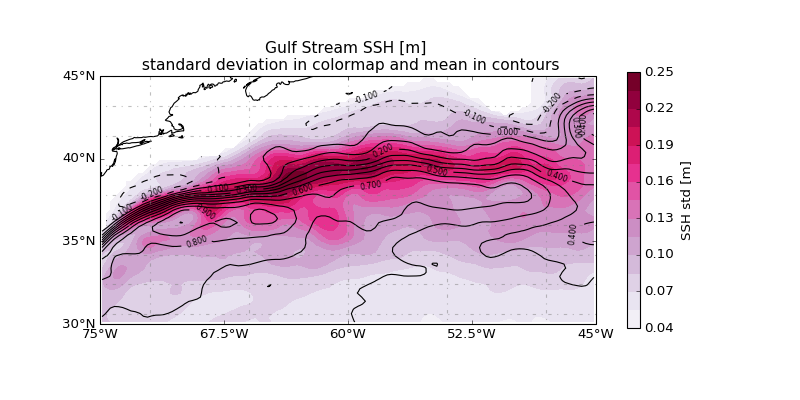

In [16]:
%matplotlib notebook

plt.close()

lon1, lon2 = reg_ext[reg]['lon']
lat1, lat2 = reg_ext[reg]['lat']
region = [lon1, lon2, lat1, lat2]    #Lon, Lat

xtick = np.linspace(lon1, lon2, num=5)
ytick = np.linspace(lat1, lat2, num=4)

x_n, y_n = Grid(gul1)
projection = ccrs.PlateCarree(360)


fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), 
                       figsize=(10,5))    
Map(ax, region, xtick, ytick)

contr1 = ax.contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='neither')
cbar = fig.colorbar(contr1, ax=ax, shrink=0.8, orientation='vertical',
                    label=cb_label, extend='neither') 
cbar.set_ticklabels(['{:.2f}'.format(i) for i in np.linspace(0.045, 0.450, 15)]) # set ticks of your format

contr2 = ax.contour(x_n, y_n, contour_var, n_lines, linewidths=1, colors='k')


ax.clabel(contr2, fontsize=7, inline=5)
ax.set_title(fig_title, fontsize=14)

#plt.savefig(dir_o + 'Gul-ssh-ms.png', bbox_inches='tight')
plt.show()